# `xarray-leaflet`

`xarray-leaflet` ist eine xarray-Erweiterung für das Plotten von gekachelten Karten. Sowohl [xarray](https://docs.xarray.dev/en/stable/) als auch [Leaflet](ipyleaflet.ipynb) können mit Datenfragmenten arbeiten, `xarray` durch [Dask Chunks](https://docs.dask.org/en/latest/array-chunks.html) und Leaflet durch *map tiles*. Mit `xarray-leaflet` arbeiten beide zusammen.

## Installation

Ihr könnt `xarray-leaflet` in eurem Jupyter-Kernel installieren mit:

``` bash
$ pipenv install xarray-leaflet
Installing xarray-leaflet…
…
``` 

Standardmäßig generiert `xarray-leaflet` Kacheln in temporären Verzeichnissen. Bei dynamischen Karten wird bei jeder Interaktion mit der Karte ein neues Verzeichnis erstellt, entweder durch Ziehen oder Zoomen. Dies liegt daran, dass eine direkte Zuordnung zwischen dem Kachelverzeichnis und der URL besteht, unter der die Kacheln bereitgestellt werden. Da bei dynamischen Karten Kacheln nicht vom Browser zwischengespeichert werden sollten, muss sich die URL ständig ändern. Diese temporären Verzeichnisse werden derzeit nicht automatisch bereinigt. Ihr solltet dies daher regelmäßig selbst tun. In ix-Systemen sind sie unter `/tmp/xarray_leaflet_*`.

## Beispiel

Um das Beispiel ausführen zu können, müsst Ihr zusätzlich die folgenden Pakete in eurem Kernel installieren:

* requests
* tqdm
* xarray-leaflet
* dask

In [1]:
import os
import warnings
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import requests
import rioxarray
import xarray_leaflet

from ipyleaflet import LayersControl, Map, WidgetControl, basemaps
from ipywidgets import FloatSlider
from tqdm import tqdm

Wir werden das DEM (Digital Elevation Model) für Europa aus dem [HydroSHEDS](https://www.hydrosheds.org)-Datensatz anzeigen, das das Terrain darstellt. Laden wir zunächst die Daten herunter:

In [2]:
url = 'https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/hydrosheds/sa_30s_zip_grid/eu_dem_30s_grid.zip'
filename = os.path.basename(url)
name = filename[:filename.find('_grid')]
adffile = os.path.join(name, name, 'w001001.adf')

if not os.path.exists(adffile):
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        total_length = int(r.headers.get('content-length'))
        for chunk in tqdm(r.iter_content(chunk_size=1024), total=(total_length/1024) + 1):
            if chunk:
                f.write(chunk)
                f.flush()
    zip = zipfile.ZipFile(filename)
    zip.extractall('.')

Es ist ein Datensatz, den [Rasterio](https://rasterio.readthedocs.io/en/stable/) öffnen kann, aber um ein schönes `DataArray` mit allen Metadaten zu erhalten, öffnen wir es mit [rioxarray](https://corteva.github.io/rioxarray/stable/):

In [3]:
da = rioxarray.open_rasterio(adffile, masked=True)
da

<xarray.DataArray (band: 1, y: 5760, x: 9480)>
[54604800 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -14.0 -13.99 -13.98 -13.97 ... 64.98 64.99 65.0
  * y            (y) float64 60.0 59.99 59.98 59.97 ... 12.03 12.02 12.01 12.0
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

Die Projektion ist `EPSG:4326` (auch bekannt als `WGS84`). Dabei entspricht die Koordinate `x` den Längengraden und `y` den Breitengraden (in Grad). Es gibt nur ein Band.

In [4]:
da = da.sel(band=1)
da.name = "DEM"

Der Datensatz kann zu groß sein, um ihn im Speicher zu halten, daher werden wir ihn in kleinere Teile zerlegen. Dies wird auch die Leistung verbessern, da die Erzeugung einer Kachel mit Dask parallel erfolgen kann.

In [5]:
da = da.chunk((1000, 1000))
warnings.filterwarnings("ignore")

Wir müssen lediglich eine Karte erstellen, bevor wir sie an unsere DataArray-Erweiterung übergeben.

In [6]:
m = Map(
    center=[52.5162, 13.3777],
    zoom=3,
    basemap=basemaps.CartoDB.Positron,
    interpolation="nearest",
)
m

Map(center=[52.5162, 13.3777], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

Um unsere Daten auf der Karte darzustellen, rufen wir `leaflet.plot()` mit unserem `DataArray` auf und übergeben die Karte als Parameter. Wir erhalten eine Ebene zurück, die wir z.B. mit einem Schieberegler zur Einstellung der Deckkraft weiter steuern können.

In [7]:
l = da.leaflet.plot(m, colormap=plt.cm.terrain)
l.interact(opacity=(0., 1.))

Url()

Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0),))

Nun fügen wir den Schieberegler in die Karte ein. Außerdem werden wir ein Ebenensteuerelement einfügen.

In [8]:
layers_control = LayersControl(position="topright")
m.add_control(layers_control)

opacity_slider = FloatSlider(description="Opacity:", min=0, max=1, value=1)


def set_opacity(change):
    l.opacity = change["new"]


opacity_slider.observe(set_opacity, names="value")
slider_control = WidgetControl(widget=opacity_slider, position="bottomleft")
m.add_control(slider_control)

Die `select()`-Methode ermöglicht es, eine Region durch Klicken und Ziehen eines Kästchens auf der Karte auszuwählen Zuvür müsst ihr jedoch auf den ⏹️-Button klicken.

In [9]:
da.leaflet.select()

Ihr könnt dann das ausgewählte Datenfeld zurückerhalten und es z.B. plotten.

In [10]:
da_selected = da.leaflet.get_selection()

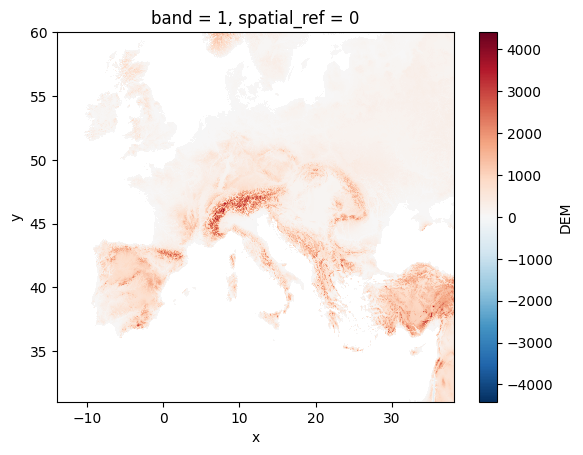

In [11]:
if da_selected is not None:
    da_selected.plot.imshow()    

Schließlich können die Auswahl und die Buttons entfernt werden:

In [12]:
da.leaflet.unselect()